# Fit halo mass to shear profile using Numcosmo statistical framework

_the LSST-DESC CLMM team_

This notebook demonstrates how to use `clmm` to estimate a WL halo mass from observations of a galaxy cluster. It uses several functionalities of the support `mock_data` module to produce datasets of increasing complexity. It relies on Numcosmo tools for the statistical analysis and shows how to fit for both cluster mass and concentration.

1. The first part of notebook is equivalent to `Example2_Fit_Halo_Mass_to_Shear_Catalog.ipynb` and demonstrates the bias introduced on the reconstructed mass by a naive fit, when the redshift distribution of the background galaxies is not properly accounted for in the model.

- Setting things up, with the proper imports.
- Generating 3 datasets: an ideal dataset (dataset1) similar to that of Example1 (single source plane); an ideal dataset but with source galaxies following the Chang et al. (2013) redshift distribution (dataset2); a noisy dataset where photoz errors and shape noise are also included (dataset3). 
- Computing the binned reduced tangential shear profile, for the 3 datasets, using logarithmic binning.
- Setting up the "single source plane" model to be fitted to the 3 datasets. Only dataset1 has a single source plane, so we expect to see a bias in the reconstructed mass when using this model on datasets 2 and 3. 
- Perform a simple fit using NumCosmo tools to compute the best-fit and the Fisher Matrix, and visualize the results.
- Perform a MCMC analysis using NumCosmo tools and visualize the results.
- Use Einasto halo density profile, fit alpha parameter.

2. In a second part, an unbinned likelihood is build to properly account for the redshift distribution, in a manner differing from that presented in `Example3_Fit_Halo_Mass_to_Shear_Catalog.ipynb`. Both the best-fit+Fisher matrix and MCMC analyses are used.


NB: to display the corner plot output of the MCMC analysis, you will need the `corner` package installed in your python environment.

## Setup

First, we import some standard packages.

In [1]:
# For NumCosmo
import os
import sys
import gi

gi.require_version('NumCosmo', '1.0')
gi.require_version('NumCosmoMath', '1.0')
from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

from scipy.stats import chi2

import math
# The corner package is needed to view the results of the MCMC analysis
import corner


os.environ['CLMM_MODELING_BACKEND'] = 'nc'

__name__ = "NcContext"

Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

In [2]:
try: import clmm
except:
    import notebook_install
    notebook_install.install_clmm_pipeline(upgrade=False)
    import clmm
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
from clmm.support.sampler import fitters

clmm.__version__

'1.0.0'

Next, we import `clmm`'s core modules.

In [3]:
import clmm.dataops as da
import clmm.galaxycluster as gc
import clmm.theory as theory
from clmm import Cosmology

We then import a support modules for a specific data sets.
`clmm` includes support modules that enable the user to generate mock data in a format compatible with `clmm`.

In [4]:
from clmm.support import mock_data as mock

## Making mock data

For reproducibility:

In [5]:
np.random.seed(11)

To create mock data, we need to define a true cosmology.

In [6]:
mock_cosmo = Cosmology(H0 = 70.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)

We now set some parameters for a mock galaxy cluster.

In [7]:
cosmo = mock_cosmo
cluster_m = 1.e15 # M200,m [Msun]
cluster_z = 0.3   # Cluster's redshift
concentration = 4
ngals = 10000     # Number of galaxies
Delta = 200
cluster_ra = 0.0
cluster_dec = 0.0

Then we use the `mock_data` support module to generate 3 galaxy catalogs:
- `ideal_data`: all background galaxies at the same redshift.
- `ideal_data_z`: galaxies distributed according to the Chang et al. (2013) redshift distribution.
- `noisy_data_z`: `ideal_data_z` + photoz errors + shape noise

In [8]:
ideal_data = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo, 0.8, ngals=ngals)
ideal_data_z = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo,'chang13', ngals=ngals)
noisy_data_z = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo, 'chang13', 
                                            shapenoise=0.05, 
                                            photoz_sigma_unscaled=0.05, ngals=ngals)

The galaxy catalogs are converted to a `clmm.GalaxyCluster` object and may be saved for later use.

In [9]:
cluster_id = "CL_ideal"
gc_object = clmm.GalaxyCluster(cluster_id, cluster_ra, cluster_dec,
                               cluster_z, ideal_data)
gc_object.save('ideal_GC.pkl')

cluster_id = "CL_ideal_z"
gc_object = clmm.GalaxyCluster(cluster_id, cluster_ra, cluster_dec,
                               cluster_z, ideal_data_z)
gc_object.save('ideal_GC_z.pkl')

cluster_id = "CL_noisy_z"
gc_object = clmm.GalaxyCluster(cluster_id, cluster_ra, cluster_dec,
                               cluster_z, noisy_data_z)
gc_object.save('noisy_GC_z.pkl')

Any saved `clmm.GalaxyCluster` object may be read in for analysis.

In [10]:
cl1 = clmm.GalaxyCluster.load('ideal_GC.pkl') # all background galaxies at the same redshift
cl2 = clmm.GalaxyCluster.load('ideal_GC_z.pkl') # background galaxies distributed according to Chang et al. (2013)
cl3 = clmm.GalaxyCluster.load('noisy_GC_z.pkl') # same as cl2 but with photoz error and shape noise

print("Cluster info = ID:", cl2.unique_id, "; ra:", cl2.ra, "; dec:", cl2.dec, "; z_l :", cl2.z)
print("The number of source galaxies is :", len(cl2.galcat))

Cluster info = ID: CL_ideal_z ; ra: 0.0 ; dec: 0.0 ; z_l : 0.3
The number of source galaxies is : 10000


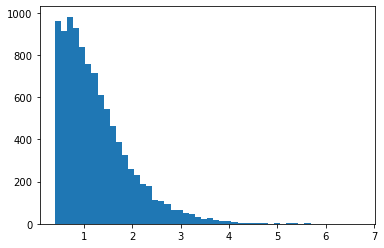

In [11]:
h = plt.hist(cl2.galcat['z'], bins=50)

## Deriving observables

### Computing shear

`clmm.dataops.compute_tangential_and_cross_components` calculates the tangential and cross shears for each source galaxy in the cluster.

In [12]:
theta1, g_t1, g_x1 = cl1.compute_tangential_and_cross_components(geometry="flat")
theta2, g_t2, g_x2 = cl2.compute_tangential_and_cross_components(geometry="flat")
theta3, g_t3, g_x3 = cl3.compute_tangential_and_cross_components(geometry="flat")

### Radially binning the data

In [13]:
bin_edges = da.make_bins(0.7, 4, 15, method='evenlog10width')

`clmm.dataops.make_radial_profile` evaluates the average shear of the galaxy catalog in bins of radius.

In [14]:
profile1 = cl1.make_radial_profile("Mpc", bins=bin_edges,cosmo=cosmo)
profile2 = cl2.make_radial_profile("Mpc", bins=bin_edges,cosmo=cosmo)
profile3 = cl3.make_radial_profile("Mpc", bins=bin_edges,cosmo=cosmo)

After running `clmm.dataops.make_radial_profile` on a `clmm.GalaxyCluster` object, the object acquires the `clmm.GalaxyCluster.profile` attribute.

In [15]:
for n in cl1.profile.colnames: cl1.profile[n].format = "%6.3e"
cl1.profile.pprint(max_width=-1)

radius_min   radius  radius_max     gt      gt_err      gx       gx_err      z       z_err     n_src  
---------- --------- ---------- --------- --------- ---------- --------- --------- --------- ---------
 7.000e-01 7.446e-01  7.863e-01 4.359e-02 1.313e-04  2.557e-18 1.074e-18 8.000e-01 2.916e-17 5.800e+01
 7.863e-01 8.403e-01  8.831e-01 3.990e-02 1.101e-04 -4.576e-19 5.526e-19 8.000e-01 2.394e-17 8.600e+01
 8.831e-01 9.395e-01  9.920e-01 3.659e-02 1.003e-04 -5.843e-19 5.125e-19 8.000e-01 3.417e-17 9.500e+01
 9.920e-01 1.052e+00  1.114e+00 3.337e-02 8.507e-05 -1.016e-18 5.666e-19 8.000e-01 1.933e-17 1.320e+02
 1.114e+00 1.187e+00  1.251e+00 3.007e-02 7.161e-05  1.298e-19 3.488e-19 8.000e-01 1.807e-17 1.510e+02
 1.251e+00 1.331e+00  1.406e+00 2.711e-02 6.612e-05  1.733e-19 3.415e-19 8.000e-01 1.718e-17 1.670e+02
 1.406e+00 1.495e+00  1.579e+00 2.428e-02 5.252e-05 -4.478e-19 2.733e-19 8.000e-01 0.000e+00 2.350e+02
 1.579e+00 1.677e+00  1.773e+00 2.167e-02 3.915e-05 -3.416e-20 1.496e-19 

We visualize the radially binned shear for the 3 configurations

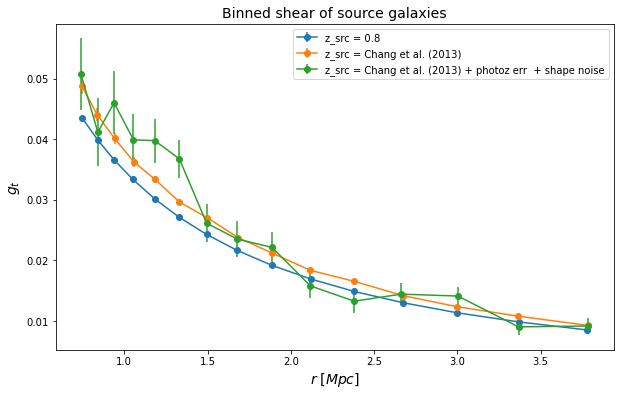

In [16]:
fig = plt.figure(figsize=(10, 6))


fsize = 14
fig.gca().errorbar(profile1['radius'], profile1['gt'], yerr=profile1['gt_err'], marker='o', label='z_src = 0.8')
fig.gca().errorbar(profile2['radius'], profile2['gt'], yerr=profile2['gt_err'], marker='o', 
                   label='z_src = Chang et al. (2013)')
fig.gca().errorbar(profile3['radius'], profile3['gt'], yerr=profile3['gt_err'], marker='o', 
                   label='z_src = Chang et al. (2013) + photoz err  + shape noise')

plt.gca().set_title(r'Binned shear of source galaxies', fontsize=fsize)
plt.gca().set_xlabel(r'$r\;[Mpc]$', fontsize=fsize)
plt.gca().set_ylabel(r'$g_t$', fontsize=fsize)
plt.legend()

### Fitting a halo mass - highlighting bias when not accounting for the source redshift distribution in the model

We estimate the best-fit mass using a simple implementation of the likelihood using a NcmDataGaussDiag object.

Here, to build the model we make the WRONG assumption that the average shear in bin $i$ equals the shear at the average redshift in the bin; i.e. we assume that $\langle g_t\rangle_i = g_t(\langle z\rangle_i)$. This should not impact `cluster 1` as all sources are located at the same redshift. However, this yields a bias in the constructed mass for `cluster 2` and `cluster 3`, where the sources followed the Chang et al. (2013) distribution.

As expected, the reconstructed mass is biased whenever the sources are not located at a single redshift as this was not accounted for in the model.

## Create the halo model

Here we model using the OO inteface, we also use NumCosmo statistical framework to perform the analysis. Below we create an object based on NumCosmo NcmDataGaussDiag (Gaussian likelihood with a diagonal covariance matrix) object. To connect with the C interface the object must implement the methods: `do_get_length`, `do_get_dof`, `do_begin`, `do_prepare` and `do_mean_func`. The last method is responsible to compute the theoretical predictions. In the param_set_ftype calls below one can change between FREE/FIXED to include/exclude the parameter from the analysis. 

Remember that here we are building the wrong model.

In [17]:
class GaussGammaTErr (Ncm.DataGaussDiag):
    z_cluster = GObject.Property (type = float, flags = GObject.PARAM_READWRITE)
    z_source  = GObject.Property (type = Ncm.Vector, flags = GObject.PARAM_READWRITE)
    r_source  = GObject.Property (type = Ncm.Vector, flags = GObject.PARAM_READWRITE)
    z_err     = GObject.Property (type = Ncm.Vector, flags = GObject.PARAM_READWRITE)

    def __init__ (self):
        Ncm.DataGaussDiag.__init__ (self, n_points = 0)        
        self.moo = clmm.Modeling ()
    
    def init_from_data (self, z_cluster, r_source, z_source, gt_profile, gt_err, z_err = None, moo = None):
        
        if moo:
            self.moo = moo
        
        assert len (gt_profile) == len (z_source)
        assert len (gt_profile) == len (r_source)
        assert len (gt_profile) == len (gt_err)
        
        self.set_size (len (gt_profile))
        
        self.props.z_cluster = z_cluster
        self.props.z_source  = Ncm.Vector.new_array (z_source)
        self.props.r_source  = Ncm.Vector.new_array (r_source)
        if z_err:
            self.props.r_source  = Ncm.Vector.new_array (z_err)
                
        self.y.set_array (gt_profile)
        
        self.sigma.set_array (gt_err) # Diagonal covariance matrix: standard deviation values in gt_err.

        
        self.set_init (True)        
    
    # Once the NcmDataGaussDiag is initialized, its parent class variable np is set with the n_points value.
    def do_get_length (self):
        return self.np

    def do_get_dof (self):
        return self.np

    def do_begin (self):
        pass

    def do_prepare (self, mset):
        self.moo.set_mset (mset)
        
    def do_mean_func (self, mset, vp):
        vp.set_array (self.moo.eval_reduced_tangential_shear (self.props.r_source.dup_array (), self.props.z_cluster, self.props.z_source.dup_array ()))
        return

GObject.type_register (GaussGammaTErr)


NcContext.GaussGammaTErr

Defining the model set (NcmMset), data set (NcmDataset) and NcmLikelihood objects to carry out a statistical analysis. 

The method `param_set_ftype` defines the parameters that can be fitted: `mid` - to which model set the parameter belongs to, `pid` - parameters' id, NcmParamType (FREE or FIXED) to say if the parameter will be fitted or not.

In [18]:
moo1 = clmm.Modeling (massdef = 'mean', delta_mdef = 200, halo_profile_model = 'einasto')
moo1.set_cosmo (cosmo)

moo2 = clmm.Modeling (massdef = 'mean', delta_mdef = 200, halo_profile_model = 'einasto')
moo2.set_cosmo (cosmo)

moo3 = clmm.Modeling (massdef = 'mean', delta_mdef = 200, halo_profile_model = 'einasto')
moo3.set_cosmo (cosmo)

ggt1 = GaussGammaTErr ()
ggt2 = GaussGammaTErr ()
ggt3 = GaussGammaTErr ()

ggt1.init_from_data (z_cluster = cluster_z, r_source = profile1['radius'], z_source = profile1['z'], gt_profile = profile1['gt'], gt_err = profile1['gt_err'], moo = moo1)
ggt2.init_from_data (z_cluster = cluster_z, r_source = profile2['radius'], z_source = profile2['z'], gt_profile = profile2['gt'], gt_err = profile2['gt_err'], moo = moo2)
ggt3.init_from_data (z_cluster = cluster_z, r_source = profile3['radius'], z_source = profile3['z'], gt_profile = profile3['gt'], gt_err = profile3['gt_err'], moo = moo3)

mset1 = ggt1.moo.get_mset ()
mset2 = ggt2.moo.get_mset ()
mset3 = ggt3.moo.get_mset ()

#Parameters: cluster mass (log base 10), concentration and alpha (Einasto parameter)
MDelta_pi = mset1.param_get_by_full_name ("NcHaloDensityProfile:log10MDelta")
cDelta_pi = mset1.param_get_by_full_name ("NcHaloDensityProfile:cDelta")
alpha_pi  = mset1.param_get_by_full_name ("NcHaloDensityProfile:alpha")

mset1.param_set_ftype (MDelta_pi.mid, MDelta_pi.pid, Ncm.ParamType.FREE)
mset1.param_set_ftype (cDelta_pi.mid, cDelta_pi.pid, Ncm.ParamType.FREE)
mset1.param_set_ftype (alpha_pi.mid, alpha_pi.pid, Ncm.ParamType.FREE)
mset1.prepare_fparam_map ()

mset2.param_set_ftype (MDelta_pi.mid, MDelta_pi.pid, Ncm.ParamType.FREE)
mset2.param_set_ftype (cDelta_pi.mid, cDelta_pi.pid, Ncm.ParamType.FREE)
mset2.param_set_ftype (alpha_pi.mid, alpha_pi.pid, Ncm.ParamType.FREE)
mset2.prepare_fparam_map ()

mset3.param_set_ftype (MDelta_pi.mid, MDelta_pi.pid, Ncm.ParamType.FREE)
mset3.param_set_ftype (cDelta_pi.mid, cDelta_pi.pid, Ncm.ParamType.FREE)
mset3.param_set_ftype (alpha_pi.mid, alpha_pi.pid, Ncm.ParamType.FREE)
mset3.prepare_fparam_map ()

dset1 = Ncm.Dataset.new ()
dset1.append_data (ggt1)
lh1 = Ncm.Likelihood.new (dset1)

dset2 = Ncm.Dataset.new ()
dset2.append_data (ggt2)
lh2 = Ncm.Likelihood.new (dset2)

dset3 = Ncm.Dataset.new ()
dset3.append_data (ggt3)
lh3 = Ncm.Likelihood.new (dset3)


### Fitting parameters: Fisher Matrix

The NcmFit object receives the NcmLikelihood and NcmMset objects. The user also indicates the fitting algorithm and the numerical differentiation method.  
Functions `run` and `fisher` computes the [best-fit](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) and the [fisher matrix](https://en.wikipedia.org/wiki/Fisher_information#Multivariate_normal_distribution), respectively. `log_info` prints the complete information about the data used, models and its parameters, and `log_covar` prints the best-fit along with the error-bar and the covariance matrix.

In [19]:
fit1 = Ncm.Fit.new (Ncm.FitType.NLOPT, "ln-neldermead", lh1, mset1, Ncm.FitGradType.NUMDIFF_FORWARD)
fit2 = Ncm.Fit.new (Ncm.FitType.NLOPT, "ln-neldermead", lh2, mset2, Ncm.FitGradType.NUMDIFF_FORWARD)
fit3 = Ncm.Fit.new (Ncm.FitType.NLOPT, "ln-neldermead", lh3, mset3, Ncm.FitGradType.NUMDIFF_FORWARD)

fit1.run (Ncm.FitRunMsgs.SIMPLE)
fit1.fisher ()
fit1.log_info ()
fit1.log_covar ()

fit2.run (Ncm.FitRunMsgs.SIMPLE)
fit2.fisher ()
fit2.log_info ()
fit2.log_covar ()

fit3.run (Ncm.FitRunMsgs.SIMPLE)
fit3.fisher ()
fit3.log_info ()
fit3.log_covar ()

#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (forward)
#................................
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:00:09.4845500
#  iteration            [000233]
#  function evaluations [000235]
#  gradient evaluations [000000]
#  degrees of freedom   [000012]
#  m2lnL     =      13.786877464322 (     13.786877 )
#  Fit parameters:
#     3.92986934110021     14.9988011358209     0.216401716790775   
#----------------------------------------------------------------------------------
# Data used:
#   - NcContext+GaussGammaTErr
#----------------------------------------------------------------------------------
# Model[03000]:
#   - NcHICosmo : Chevalier-Polarski-Linder parametrization
#---------------------------------------------------------

# Model parameters
#   -      cDelta[00]:  4.22372537047284    [FREE]
#   - log10MDelta[01]:  14.9070566669922    [FREE]
#   -       alpha[02]:  0.343259948926825   [FREE]
#----------------------------------------------------------------------------------
# Model[10000]:
#   - NcWLSurfaceMassDensity : WL Surface Mass Density
#----------------------------------------------------------------------------------
# Model parameters
#   -         pcc[00]:  0.8                 [FIXED]
#   -        Roff[01]:  1                   [FIXED]
#----------------------------------------------------------------------------------
# NcmMSet parameters covariance matrix
#                                                       ----------------------------------------------
#      cDelta[06000:00] =  4.224       +/-  0.8613      |  1           |  0.01556     | -0.8755      |
# log10MDelta[06000:01] =  14.91       +/-  0.02819     |  0.01556     |  1           | -0.3777      |
#       alpha[06000:02] =  0.3433 

## Visualization of the results

For visualization purpose, we calculate the reduced tangential shear predicted by the model when using the average redshift of the catalog.

In [20]:
rr = np.logspace(-0.5, np.log10(5), 100)

gt_model1 = moo1.eval_reduced_tangential_shear (rr, cluster_z, np.mean(cl1.galcat['z']))
gt_model2 = moo2.eval_reduced_tangential_shear (rr, cluster_z, np.mean(cl2.galcat['z']))
gt_model3 = moo3.eval_reduced_tangential_shear (rr, cluster_z, np.mean(cl3.galcat['z']))

m_est1 = 10**mset1.param_get (MDelta_pi.mid, MDelta_pi.pid)
m_est2 = 10**mset2.param_get (MDelta_pi.mid, MDelta_pi.pid)
m_est3 = 10**mset3.param_get (MDelta_pi.mid, MDelta_pi.pid)

# Standard deviation
m_est_err1 = fit1.covar_sd (MDelta_pi.mid, MDelta_pi.pid) * m_est1 * math.log (10.0)
m_est_err2 = fit2.covar_sd (MDelta_pi.mid, MDelta_pi.pid) * m_est2 * math.log (10.0)
m_est_err3 = fit3.covar_sd (MDelta_pi.mid, MDelta_pi.pid) * m_est3 * math.log (10.0)

print ("% 22.15e +/- %.0e % 22.15e +/- %.0e % 22.15e +/- %.0e" % (m_est1, m_est_err1, m_est2, m_est_err2, m_est3, m_est_err3))

 9.972433198527250e+14 +/- 7e+11  8.680632264036871e+14 +/- 3e+12  8.073403656089111e+14 +/- 5e+13


We visualize that prediction of reduced tangential shears along with the data

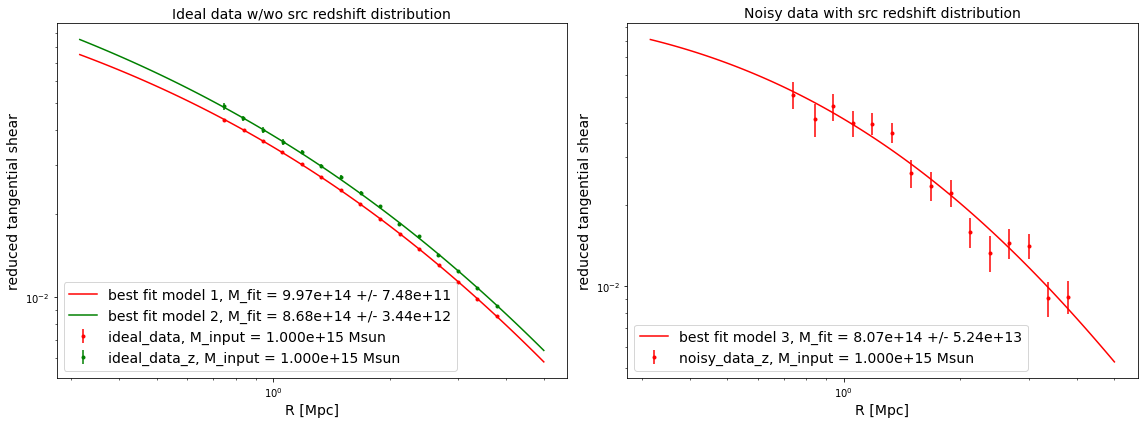

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

axes[0].errorbar(profile1['radius'], profile1['gt'],profile1['gt_err'], color='red',
                 label='ideal_data, M_input = %.3e Msun' % cluster_m, fmt='.')
axes[0].plot(rr, gt_model1,color='red',
             label='best fit model 1, M_fit = %.2e +/- %.2e' % (m_est1, m_est_err1))


axes[0].errorbar(profile2['radius'], profile2['gt'],profile2['gt_err'], color='green',
                  label='ideal_data_z, M_input = %.3e Msun' % cluster_m, fmt='.')
axes[0].plot(rr, gt_model2, color='green',
               label='best fit model 2, M_fit = %.2e +/- %.2e' % (m_est2, m_est_err2))
axes[0].set_title('Ideal data w/wo src redshift distribution',fontsize=fsize)
axes[0].semilogx()
axes[0].semilogy()
axes[0].legend(fontsize=fsize)
axes[0].set_xlabel('R [Mpc]', fontsize=fsize)
axes[0].set_ylabel('reduced tangential shear', fontsize=fsize)

axes[1].errorbar(profile3['radius'], profile3['gt'],profile3['gt_err'], color='red',
                label='noisy_data_z, M_input = %.3e Msun' % cluster_m, fmt='.')
axes[1].plot(rr, gt_model3,color='red',
             label='best fit model 3, M_fit = %.2e +/- %.2e' % (m_est3, m_est_err3))
axes[1].set_title('Noisy data with src redshift distribution',fontsize=fsize)
axes[1].semilogx()
axes[1].semilogy()
axes[1].legend(fontsize=fsize)
axes[1].set_xlabel('R [Mpc]', fontsize=fsize)
axes[1].set_ylabel('reduced tangential shear', fontsize=fsize)

fig.tight_layout()

### To investigate further the results we make a MCMC analysis below.

We begin by specifying if the run is single- or multi-thread: `func_eval_set_max_threads` sets the maximum number of threads, and `func_eval_log_pool_stats` prints the information about the thread pool.

Then, we initialize the transition kernel object (NcmMSetTransKern) which defines the distribution of the initial points of the parameter space to be used by the ensemble sampler. In this example we use the Gaussian transition kernel (NcmMSetTransKernGauss), with priors provided by the NcmMset (`set_prior_from_mset`). `set_cov_from_rescale` sets the covariance matrix with zero correlation and the diagonal terms defined by the scale of each parameter times the argument of `set_cov_from_rescale`. 

Here we use the Ensemble Sampler MCMC (ESMCMC) method. `nwalkers` and `walker` define the number of walkers and the algorithm used to move the points in the ensemble. 
Running: `start_run`, `run_lre` and `end_run`. `run_lre` runs the ESMCMC until the relative error of the mean of each parameter is smaller than $10^{-3}$. Its first argument (integer) indicates how many ensembles are computed before applying any convergence test.

In the end we save the catalog to mcat_wrong to compare with a correct analysis.

In [ ]:
Ncm.func_eval_set_max_threads (0)
Ncm.func_eval_log_pool_stats ()

init_sampler = Ncm.MSetTransKernGauss.new (0)
init_sampler.set_mset (mset3)
init_sampler.set_prior_from_mset ()
init_sampler.set_cov_from_rescale (1.0e-1)

nwalkers = 800 # Number of walkers
walker = Ncm.FitESMCMCWalkerAPES.new (nwalkers, mset3.fparams_len ())

# Ensemble Sampler MCMC
esmcmc  = Ncm.FitESMCMC.new (fit3, nwalkers, init_sampler, walker, Ncm.FitRunMsgs.SIMPLE)
esmcmc.set_data_file ("example2_fit3_wrong_esmcmc_out_aps.fits")
esmcmc.set_auto_trim (True)            # Detect and discard the burn-in points.
esmcmc.set_auto_trim_div (100)
esmcmc.set_max_runs_time (2.0 * 60.0)  # Maximum time between tests.

esmcmc.start_run ()
esmcmc.run_lre (20, 1.0e-3)
esmcmc.end_run ()

mcat_wrong = esmcmc.peek_catalog ()

# NcmThreadPool:Unused:      0
# NcmThreadPool:Max Unused:  2
# NcmThreadPool:Running:     0
# NcmThreadPool:Unprocessed: 0
# NcmThreadPool:Unused:      0
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Starting Ensamble Sampler Markov Chain Monte Carlo.
#   Number of walkers: 0800.
#   Number of threads: 0000.
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Skipping 12800 points (16.000000 iterations), will start at 12801-th point.
#----------------------------------------------------------------------------------
# NcmFitESMCMC: validating catalog rows [12000, 12800)
# NcmFitESMCMC: samples rows [12000, 12800) successfully validated.
# NcmFitESMCMC: Running first 4 pre-runs...
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Calculating [000004] Ensemble Sampler Markov Chain Monte Carlo runs [APES-Move:VKDE:Cauchy]
# Task:NcmFitESM

#----------------------------------------------------------------------------------
# NcmMSetCatalog: Computing the constant break point for parameter `0', sample size `22':
# NcmMSetCatalog: Constant break point at `7':
# NcmFitESMCMC:acceptance ratio 51.8333% (last update 51.0000%), offboard ratio  0.0000% (last update  0.0000%).
# NcmFitESMCMC:last ensemble variance of -2ln(L):       4.86446516785572 (2n = 6), min(-2ln(L)) =       12.7193030750266.
# Task:NcmFitESMCMC, completed: 4800 of 11200, elapsed time: 00:02:47.2971
# Task:NcmFitESMCMC, mean time: 00:00:00.0348 +/- 00:00:00.0142
# Task:NcmFitESMCMC, time left: 00:03:42.9971 +/- 00:01:31.0015
# Task:NcmFitESMCMC, current time:        Tue Sep 28 2021, 15:46:25
# Task:NcmFitESMCMC, estimated to end at: Tue Sep 28 2021, 15:50:08 +/- 00:01:31.0015
# NcmMSetCatalog: Current mean:   15.713       4.6744       14.909       0.28771    
# NcmMSetCatalog: Current msd:    0.060376     0.020343     0.00066002   0.0018111  
# NcmMSetCatalog:

# NcmMSetCatalog: Constant break point at `6':
# NcmFitESMCMC:acceptance ratio 52.3906% (last update 54.1250%), offboard ratio  0.0000% (last update  0.0000%).
# NcmFitESMCMC:last ensemble variance of -2ln(L):       3.75737966275501 (2n = 6), min(-2ln(L)) =       12.7193030750266.
# Task:NcmFitESMCMC, completed: 12800 of 19200, elapsed time: 00:07:39.5626
# Task:NcmFitESMCMC, mean time: 00:00:00.0359 +/- 00:00:00.0090
# Task:NcmFitESMCMC, time left: 00:03:49.7581 +/- 00:00:57.4972
# Task:NcmFitESMCMC, current time:        Tue Sep 28 2021, 15:51:17
# Task:NcmFitESMCMC, estimated to end at: Tue Sep 28 2021, 15:55:07 +/- 00:00:57.4972
# NcmMSetCatalog: Current mean:   15.585       4.829        14.91        0.26904    
# NcmMSetCatalog: Current msd:    0.044596     0.029576     0.00074245   0.0025012  
# NcmMSetCatalog: Current sd:     3.6592       1.0001       0.030517     0.085183   
# NcmMSetCatalog: Current var:    13.39        1.0001       0.00093132   0.0072562  
# NcmMSetCatalog: Cu

# Task:NcmFitESMCMC, completed: 20800 of 27200, elapsed time: 00:12:48.7359
# Task:NcmFitESMCMC, mean time: 00:00:00.0370 +/- 00:00:00.0073
# Task:NcmFitESMCMC, time left: 00:03:56.5218 +/- 00:00:46.4450
# Task:NcmFitESMCMC, current time:        Tue Sep 28 2021, 15:56:27
# Task:NcmFitESMCMC, estimated to end at: Tue Sep 28 2021, 16:00:24 +/- 00:00:46.4450
# NcmMSetCatalog: Current mean:   15.518       4.9181       14.911       0.25884    
# NcmMSetCatalog: Current msd:    0.035775     0.030502     0.00062374   0.0023804  
# NcmMSetCatalog: Current sd:     3.3597       1.0508       0.030002     0.083358   
# NcmMSetCatalog: Current var:    11.287       1.1042       0.00090012   0.0069486  
# NcmMSetCatalog: Current tau:    3.9913       29.659       15.214       28.703     
# NcmMSetCatalog: Current skfac:  1.0235       1.0187       1.0191       1.0151     
# NcmMSetCatalog: Maximal Shrink factor = 1.02354               
#------------------------------------------------------------------

# Task:NcmFitESMCMC, current time:        Tue Sep 28 2021, 16:01:36
# Task:NcmFitESMCMC, estimated to end at: Tue Sep 28 2021, 16:05:36 +/- 00:00:39.9501
# NcmMSetCatalog: Current mean:   15.461       4.9756       14.911       0.252      
# NcmMSetCatalog: Current msd:    0.030094     0.028797     0.00055466   0.0021805  
# NcmMSetCatalog: Current sd:     3.1456       1.0738       0.02949      0.081687   
# NcmMSetCatalog: Current var:    9.8947       1.1531       0.00086965   0.0066727  
# NcmMSetCatalog: Current tau:    3.9539       31.066       15.283       30.781     
# NcmMSetCatalog: Current skfac:  1.0186       1.016        1.015        1.0127     
# NcmMSetCatalog: Maximal Shrink factor = 1.01993               
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Computing the constant break point for parameter `0', sample size `54':
# NcmMSetCatalog: Constant break point at `6':
# NcmFitESMCMC:acceptance ratio 53.5888% (last upd

# NcmMSetCatalog: Current mean:   15.426       5.0117       14.911       0.24782    
# NcmMSetCatalog: Current msd:    0.026388     0.027413     0.00047418   0.0020003  
# NcmMSetCatalog: Current sd:     3.0036       1.0858       0.029235     0.079979   
# NcmMSetCatalog: Current var:    9.0216       1.179        0.00085471   0.0063966  
# NcmMSetCatalog: Current tau:    3.9519       32.632       13.469       32.027     
# NcmMSetCatalog: Current skfac:  1.0156       1.0128       1.013        1.0103     
# NcmMSetCatalog: Maximal Shrink factor = 1.01502               
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Computing the constant break point for parameter `0', sample size `64':
# NcmMSetCatalog: Constant break point at `6':
# NcmFitESMCMC:acceptance ratio 53.9297% (last update 55.6250%), offboard ratio  0.0000% (last update  0.0000%).
# NcmFitESMCMC:last ensemble variance of -2ln(L):       4.21773032553789 (2n = 6), min(-2ln

# NcmMSetCatalog: Current msd:    0.023565     0.025404     0.00043287   0.0018326  
# NcmMSetCatalog: Current sd:     2.8861       1.0959       0.028978     0.078639   
# NcmMSetCatalog: Current var:    8.3294       1.2009       0.00083974   0.0061842  
# NcmMSetCatalog: Current tau:    3.9468       31.814       13.21        32.149     
# NcmMSetCatalog: Current skfac:  1.0136       1.0115       1.0116       1.0087     
# NcmMSetCatalog: Maximal Shrink factor = 1.01314               
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Computing the constant break point for parameter `0', sample size `74':
# NcmMSetCatalog: Constant break point at `6':
# NcmFitESMCMC:acceptance ratio 54.0496% (last update 53.8750%), offboard ratio  0.0000% (last update  0.0000%).
# NcmFitESMCMC:last ensemble variance of -2ln(L):       4.20929257119085 (2n = 6), min(-2ln(L)) =       12.7193030750266.
# Task:NcmFitESMCMC, completed: 46400 of 51200, elapse

# NcmMSetCatalog: Current sd:     2.7956       1.1019       0.028818     0.07742    
# NcmMSetCatalog: Current var:    7.8152       1.2142       0.00083049   0.0059939  
# NcmMSetCatalog: Current tau:    3.9374       31.217       11.372       31.706     
# NcmMSetCatalog: Current skfac:  1.0119       1.011        1.01         1.008      
# NcmMSetCatalog: Maximal Shrink factor = 1.01217               
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Computing the constant break point for parameter `0', sample size `84':
# NcmMSetCatalog: Constant break point at `6':
# NcmFitESMCMC:acceptance ratio 54.0643% (last update 56.3750%), offboard ratio  0.0000% (last update  0.0000%).
# NcmFitESMCMC:last ensemble variance of -2ln(L):       4.13865130351571 (2n = 6), min(-2ln(L)) =       12.7193030750266.
# Task:NcmFitESMCMC, completed: 54400 of 59200, elapsed time: 00:32:10.8716
# Task:NcmFitESMCMC, mean time: 00:00:00.0355 +/- 00:00:00.0044

KeyboardInterrupt: 

## Correct non- projected model

Here, instead of building an object directly on top of NcmDataGauss*, we use NumCosmo's framework to build non-binned likelihood for weak-lensing cluster analysis.

For that we need two objects: a NcGalaxyWLReducedShearGauss that model a Gaussian distributed reduced shear likelihood, here the observables matrix is simply $(r, \gamma_t, \sigma_{\gamma_t})$ for each galaxy. If the data has spectroscopic redshifts then we use NcGalaxyRedshiftSpec with an array of real redshifts. When photometric errors are included we use the NcGalaxyRedshiftGauss object that receives $(z, \sigma_z)$ for each galaxy. 

Once we have the data objects ready we can proceed as in the previous examples.


In [ ]:
def create_nc_data_cluster_wl (theta, g_t, z_source, z_cluster, cosmo, dist, sigma_z = None, sigma_g = None):
    r  = clmm.convert_units (theta, "radians", "Mpc", redshift = z_cluster, cosmo = cosmo)
    ga = Ncm.ObjArray.new ()
    
    sigma_g = 1.0e-4 if not sigma_g else sigma_g
    m_obs = np.column_stack ((r, g_t, np.repeat (sigma_g, len (r))))
    
    grsg = Nc.GalaxyWLReducedShearGauss (pos = Nc.GalaxyWLReducedShearGaussPos.R)
    grsg.set_obs (Ncm.Matrix.new_array (m_obs.flatten (), 3))
    
    if sigma_z:
        gzgs = Nc.GalaxyRedshiftGauss ()
        z_obs = np.column_stack ((z_source, (1.0 + z_source) * sigma_z))
        gzgs.set_obs (Ncm.Matrix.new_array (z_obs.flatten (), 2))
    else:
        gzgs = Nc.GalaxyRedshiftSpec ()
        gzgs.set_z (Ncm.Vector.new_array (z_source))

    gwl  = Nc.GalaxyWL (wl_dist = grsg, gz_dist = gzgs)
    ga.add (gwl)

    nc_dcwl = Nc.DataClusterWL (galaxy_array = ga, z_cluster = z_cluster)
    nc_dcwl.set_init (True)
    
    return nc_dcwl

def create_fit_obj (data_array, mset):
    dset = Ncm.Dataset.new ()
    for data in data_array:
        dset.append_data (data)
    lh = Ncm.Likelihood.new (dset)
    fit = Ncm.Fit.new (Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_FORWARD)
    #fit.set_params_reltol (1.0e-8)
    #fit.set_m2lnL_reltol (1.0e-11)
    
    return fit

ggt1 = create_nc_data_cluster_wl (theta1, g_t1, cl1.galcat['z'], cluster_z, cosmo, cosmo.dist, sigma_z = None, sigma_g = None)
ggt2 = create_nc_data_cluster_wl (theta2, g_t2, cl2.galcat['z'], cluster_z, cosmo, cosmo.dist, sigma_z = None, sigma_g = None)
ggt3 = create_nc_data_cluster_wl (theta3, g_t3, cl3.galcat['z'], cluster_z, cosmo, cosmo.dist, sigma_z = 0.05, sigma_g = 0.05)


As the likelihood is not Gaussian, here we compute the [Observed Fisher Matrix](https://en.wikipedia.org/wiki/Observed_information) (`obs_fisher`).

In [ ]:
fit1 = create_fit_obj ([ggt1], mset1)
fit2 = create_fit_obj ([ggt2], mset2)
fit3 = create_fit_obj ([ggt3], mset3)

fit1.run (Ncm.FitRunMsgs.SIMPLE)
fit1.obs_fisher ()
fit1.log_covar ()

fit2.run (Ncm.FitRunMsgs.SIMPLE)
fit2.obs_fisher ()
fit2.log_covar ()

fit3.run (Ncm.FitRunMsgs.SIMPLE)
fit3.obs_fisher ()
fit3.log_covar ()

mest1 = 10**mset1.param_get (MDelta_pi.mid, MDelta_pi.pid)
mest2 = 10**mset2.param_get (MDelta_pi.mid, MDelta_pi.pid)
mest3 = 10**mset3.param_get (MDelta_pi.mid, MDelta_pi.pid)

print ("% 22.15e % 22.15e % 22.15e" % (mest1, mest2, mest3))

## Visualizing the results

Note below that we no longer have biased results, all results are well within the error bars. Note also that the error bars are substantially smaller than in the binned case.

In [ ]:
rr = np.logspace(-0.5, np.log10(5), 100)

gt_model1 = moo1.eval_reduced_tangential_shear (rr, cluster_z, np.mean(cl1.galcat['z']))
gt_model2 = moo2.eval_reduced_tangential_shear (rr, cluster_z, np.mean(cl2.galcat['z']))
gt_model3 = moo3.eval_reduced_tangential_shear (rr, cluster_z, np.mean(cl3.galcat['z']))

m_est1 = 10**mset1.param_get (MDelta_pi.mid, MDelta_pi.pid)
m_est2 = 10**mset2.param_get (MDelta_pi.mid, MDelta_pi.pid)
m_est3 = 10**mset3.param_get (MDelta_pi.mid, MDelta_pi.pid)

m_est_err1 = fit1.covar_sd (MDelta_pi.mid, MDelta_pi.pid) * m_est1 * math.log (10.0)
m_est_err2 = fit2.covar_sd (MDelta_pi.mid, MDelta_pi.pid) * m_est2 * math.log (10.0)
m_est_err3 = fit3.covar_sd (MDelta_pi.mid, MDelta_pi.pid) * m_est3 * math.log (10.0)

print ("% 22.15e +/- %.0e % 22.15e +/- %.0e % 22.15e +/- %.0e" % (m_est1, m_est_err1, m_est2, m_est_err2, m_est3, m_est_err3))

### To investigate further the results we make a MCMC analysis below.

In [ ]:
Ncm.func_eval_set_max_threads (0)
Ncm.func_eval_log_pool_stats ()

init_sampler = Ncm.MSetTransKernGauss.new (0)
init_sampler.set_mset (mset3)
init_sampler.set_prior_from_mset ()
init_sampler.set_cov_from_rescale (1.0e-1)

nwalkers = 800
stretch = Ncm.FitESMCMCWalkerAPES.new (nwalkers, mset3.fparams_len ())

esmcmc  = Ncm.FitESMCMC.new (fit3, nwalkers, init_sampler, stretch, Ncm.FitRunMsgs.SIMPLE)
esmcmc.set_data_file ("example4_fit3_esmcmc_out_aps.fits")
esmcmc.set_auto_trim (True)
esmcmc.set_auto_trim_div (100)
esmcmc.set_max_runs_time (2.0 * 60.0)

esmcmc.start_run ()
esmcmc.run_lre (20, 1.0e-3)
esmcmc.end_run ()


### Below we plot both MCMC results

The wrong analysis has a strong bias in $\log_{10}(M_\Delta)$ (the peak of the wrong model is more than $3\sigma$ away from the correct model best-fit) and much larger variance.

In [ ]:

s1d1 = chi2.cdf (1.0, df = 1)
s1d2 = chi2.cdf (4.0, df = 1)
s2d1 = chi2.cdf (1.0, df = 2)
s2d2 = chi2.cdf (4.0, df = 2)
s2d3 = chi2.cdf (9.0, df = 2)
qts = [0.5 - s1d2 / 2.0, 0.5 - s1d1 / 2.0, 0.5, 0.5 + s1d1 / 2.0, 0.5 + s1d2 / 2.0]

mcat = esmcmc.peek_catalog ()
rows = np.array ([mcat.peek_row (i).dup_array () for i in range (nwalkers * 10, mcat.len ())])
params = ["$" + mcat.col_symb (i) + "$" for i in range (mcat.ncols ())]
figure = corner.corner (rows[:,1:], labels = params[1:], reverse = False,
                        quantiles=qts, levels = (s2d1, s2d2, s2d3), 
                        bins = 40, smooth = 0.8, smooth1d = 0.8, color = (0.5, 0.2, 0.5, 1.0))

rows = np.array ([mcat_wrong.peek_row (i).dup_array () for i in range (nwalkers * 10, mcat_wrong.len ())])
params = ["$" + mcat_wrong.col_symb (i) + "$" for i in range (mcat_wrong.ncols ())]
figure = corner.corner (rows[:,1:], labels = params[1:], range=[(2.9, 9.5), (14.8, 15.12)], reverse = False,
                        levels = (s2d1, s2d2, s2d3), color = (0.1, 0.2, 0.5, 0.5),
                        bins = 40, smooth = 0.8, smooth1d = 0.8, fig = figure)


figure.set_size_inches(12, 6)

In [ ]:
ser = Ncm.Serialize.new (0)
data = fit3.lh.dset.get_data (0)
ser.to_file (data, "example4_fit3_data.obj")